In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
"""
This file contains the following variables that you need:
    - y and s: the problem data.
    - T, N, M: the problem dimensions.
    - a_true: the true value for you to compare against.
We also provide the following helper functions for plotting and other utility:
    - visualize_data(): Generates a plot of y, and s * a_true.
        Call plt.show() after calling the function to make the plot visible.
    - visualize_estimate(a): Generates a plot of y, estimated hat a, and s * hat a.
        Call plt.show() after calling the function to make the plot visible.
        Here, a needs to be an array of values, not cvxpy variable!
    - visualize_polished(a_polished): Generates a plot of y, a_polished, and s * a_polished.
        Call plt.show() after calling the function to make the plot visible.
        Here, a_polished needs to be an array of values, not cvxpy variable!
    - find_nonzero_entries(a): Given the vector a, this function returns the
        indices where a > 0.01.
        Here, a needs to be an array of values, not cvxpy variable!
"""

import numpy as np
import matplotlib.pyplot as plt

################################################################################
# This section of the code sets up a discrete version of the Hodgkin Huxley (H&H)
# model, about which you need to know absolutely nothing.
# The H&H model is used to obtain a realistic template of neural activity.
# You do not need to know or understand any of the code until the next line
# of all #s

# Define model parameters
Cm = 1.0   # Membrane capacitance
I_app = 10.0  # Applied current
E_Na = 55.0   # Sodium reversal potential
E_K = -90.0   # Potassium reversal potential
E_L = -65.0   # Leak reversal potential
g_Na = 120.0   # Maximum sodium conductance
g_K = 36.0   # Maximum potassium conductance
g_L = 0.3   # Maximum leak conductance

# Define time vector
dt = 0.01   # Time step
t_max = 20.0   # Maximum time
t = np.arange(0, t_max + dt, dt)

# Define initial conditions
V = -65.0   # Membrane potential
m = 0.0   # Sodium activation gate
h = 1.0   # Sodium inactivation gate
n = 0.0   # Potassium activation gate

# Define functions for the ion currents and gating variables
def alpha_m(V):
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

def alpha_n(V):
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65.0) / 80.0)

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_K(V, n):
    return g_K * n**4 * (V - E_K)

def I_L(V):
    return g_L * (V - E_L)

# Simulate the H&H model
V_trace = [V]
for i in range(len(t)-1):
    m += dt * (alpha_m(V) * (1.0 - m) - beta_m(V) * m)
    h += dt * (alpha_h(V) * (1.0 - h) - beta_h(V) * h)
    n += dt * (alpha_n(V) * (1.0 - n) - beta_n(V) * n)
    I_ion = I_Na(V, m, h) + I_K(V, n) + I_L(V)
    V += dt * (I_app - I_ion) / Cm
    V_trace.append(V)


# We subsample the template in time for shorter final result
t_sub = t[::10]
V_sub = V_trace[::10]

s = V_sub[:200] - V_sub[199]
M = s.shape[0]
N = 2000

# This generates the ground truth activations a_true
a_true = np.zeros(N)
acts = np.array([200,250,345,460,500, 800, 850, 1100, 1500, 1700], dtype=int)
np.random.seed(50)
for i in range(acts.shape[0]):
    a_true[acts[i]] = np.maximum(np.random.normal(1,0.3),1)
# We generate the ground truth signal
y = np.convolve(s, a_true) + np.random.normal(0,80,M+N-1)

# We divide by 8 to achieve realistic bounds on the ephys recording
y = y / 8
s = s / 8

# The time axis is in data points, not ms!
times = np.arange(0,2199,1)
T = M + N - 1
################################################################################

# Use the plotting functions provided below whenever helpful.

def visualize_data():
    plt.subplots(2,1)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=1)

    plt.subplot(211)
    plt.plot(times,y)
    plt.ylabel('y (mV)')
    plt.xlabel('t')

    plt.subplot(212)
    plt.plot(times,np.convolve(s,a_true),label = 'True')
    plt.ylabel('$s * a_{true}$')
    plt.xlabel('t')

def visualize_estimate(a):
    plt.subplots(3,1)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.4)

    plt.subplot(311)
    plt.plot(times,y)
    plt.ylabel('y (mV)')

    plt.subplot(312)
    plt.plot(times,np.convolve(s,a_true),label = 'True',linewidth = 3, alpha=0.7)
    plt.plot(times,np.convolve(s,a),label = 'Estimated')
    plt.ylabel(r's * $\hat{a}$')

    plt.subplot(313)
    plt.plot(times[:2000],a_true,label = '$True$',linewidth = 3, alpha=0.7)
    plt.plot(times[:2000],a,label = '$Estimated$')
    plt.ylabel(r'$\hat{a}$')
    plt.legend()
    plt.xlabel('t')

def visualize_polished(a):
    plt.subplots(3,1)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.4)

    plt.subplot(311)
    plt.plot(times,y)
    plt.ylabel('y (mV)')

    plt.subplot(312)
    plt.plot(times,np.convolve(s,a_true),label = 'True',linewidth = 3, alpha=0.7)
    plt.plot(times,np.convolve(s,a),label = 'Estimated')
    plt.ylabel(r's * $\hat{a}_{polished}$')

    plt.subplot(313)
    plt.plot(times[:2000],a_true,label = '$True$',linewidth = 3, alpha=0.7)
    plt.plot(times[:2000],a,label = '$Estimated$')
    plt.ylabel(r'$\hat{a}_{polished}$')
    plt.legend()
    plt.xlabel('t')

def find_nonzero_entries(a):
    ind = np.where(a > 0.01)[0]
    return ind

### Regularized problem

In [3]:
def solve_convex_problem():
  lam = 2.0

  a_hat = cp.Variable((len(a_true), 1))

  first_obj = cp.sum_squares(y - cp.conv(s, a_hat).flatten())
  second_obj = cp.norm1(a_hat)
  objective = (1/T)*first_obj + lam *second_obj
  constraints = [a_hat >= 0]
  cp.Problem(cp.Minimize(objective), constraints).solve()
  a_hat = a_hat.value
  a_hat_seed = a_hat[:, 0]
  a_hat = a_hat[:, 0]

  return a_hat

a_hat_regularized = solve_convex_problem()

### Polishing

In [8]:
def solve_polishing(a_hat_seed):
  non_zero_entries = find_nonzero_entries(a_hat_seed)

  a_hat = cp.Variable((len(a_true), 1))

  objective = (1/T) * cp.sum_squares(y - cp.conv(s, a_hat).flatten())

  constraints = [a_hat >= 0]

  for i in np.arange(len(a_true)):
    if i not in non_zero_entries:
      constraints += [a_hat[i] == 0]

  cp.Problem(cp.Minimize(objective), constraints).solve()
  a_hat = a_hat.value
  a_hat = a_hat[:, 0]

  return a_hat

a_hat_polished = solve_polishing(a_hat_regularized)

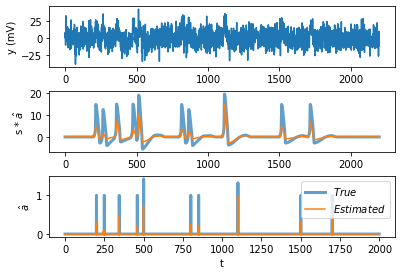

In [5]:
visualize_estimate(a_hat_regularized)

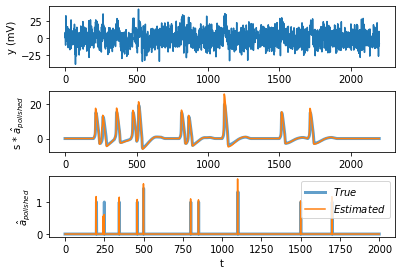

In [9]:
visualize_polished(a_hat_polished)

In [10]:
print(f"Non zero entries in true signal :{len(find_nonzero_entries(a_true))}")
print(f"Non zero enties in regularized signal :{len(find_nonzero_entries(a_hat_regularized))}")
print(f"Non zero enties in polished signal :{len(find_nonzero_entries(a_hat_polished))}")

Non zero entries in true signal :10
Non zero enties in regularized signal :11
Non zero enties in polished signal :11


In [11]:
print(f"Non zero entries in true signal :{find_nonzero_entries(a_true)}")
print(f"Non zero enties in regularized signal :{find_nonzero_entries(a_hat_regularized)}")
print(f"Non zero enties in polished signal :{find_nonzero_entries(a_hat_polished)}")

Non zero entries in true signal :[ 200  250  345  460  500  800  850 1100 1500 1700]
Non zero enties in regularized signal :[ 198  242  249  345  459  499  799  849 1098 1499 1698]
Non zero enties in polished signal :[ 198  242  249  345  459  499  799  849 1098 1499 1698]
